In [1]:
from hlm import HSAR
from hlm.dong_harris.verify import Delta_members
import hlm
import scipy.sparse as spar
from sims import dgp
import pysal as ps
import pandas as pd
import numpy as np

In [2]:
W = ps.open('./test_data/w_lower.mtx').read()
M = ps.open('./test_data/w_upper.mtx').read()
df = pd.read_csv('./test_data/test.csv')

In [3]:
df.head()

,id,u.full,y,x,county
0,0,-0.689048,0.788457,1,1
1,1,-0.689048,0.788457,0,1
2,2,-0.689048,1.064711,0,1
3,3,-0.689048,0.000000,0,1
4,4,-0.847313,1.131402,0,2


In [4]:
membership = df[['county']].values - 1

In [5]:
W.transform = M.transform = 'r'

In [6]:
Wmat = W.sparse
Mmat = M.sparse

In [7]:
Delta, mems = Delta_members(Delta = None, membership=membership, N=W.n, J=M.n)

In [8]:
Betas, Sigma2_e, Sigma2_u, Rho, Lambda = dgp.setup_params()

In [9]:
y, X = dgp.dgp(Betas, Sigma2_e, Sigma2_u, Rho, W, Lambda, M, Delta)

In [10]:
ps.spreg.OLS(y,X).betas

array([[ 8.91340042],
       [-2.17615497],
       [ 4.27040791],
       [-6.22992398],
       [ 8.41329776]])

In [11]:
Betas

array([[-2],
       [ 4],
       [-6],
       [ 8]])

In [12]:
W_min, W_max = hlm.utils.speigen_range(Wmat)
M_min, M_max = hlm.utils.speigen_range(Mmat)

/home/ljw/dev/hlm/hlm/utils.py:141: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


In [13]:
rhogrid = np.arange(1./W_min, 1./W_max, .01)
lamgrid = np.arange(1./M_min, 1./M_max, .01)

In [14]:
In = np.identity(W.n)
Ij = np.identity(M.n)

In [15]:
As = [spar.csc_matrix(In - r*Wmat) for r in rhogrid]
Bs = [spar.csc_matrix(Ij - l*Mmat) for l in lamgrid]

In [16]:
rhodets = np.hstack([hlm.utils.splogdet(A) for A in As])
lamdets = np.hstack([hlm.utils.splogdet(B) for B in Bs])

In [17]:
rhos = np.vstack((rhogrid, rhodets))
lams = np.vstack((lamgrid, lamdets))

In [35]:
dh = HSAR(y, X, W, M, membership=membership, rho_grid = rhos, 
          spatial_method='met', effects_method='cho',
          lambda_grid = lams, n_samples=1000, truncate=(W_min, W_max, M_min, M_max), 
          Rho=-.5, Lambda=.5,
          rho_jump=1, lambda_jump=1, rho_adapt_step=1.05, lambda_adapt_step=1.05,
          tuning=100)

applied ['overwrite_covariance'] to Betas
applied ['overwrite_covariance'] to Thetas
applied [] to Sigma2_e
applied [] to Sigma2_u
applied ['adapt_step', 'proposal', 'jump', 'ar_low', 'ar_hi', 'grid'] to Rho
applied ['adapt_step', 'proposal', 'jump', 'ar_low', 'ar_hi', 'grid'] to Lambda


In [64]:
df = pd.DataFrame().from_records(dh.trace._data)

In [44]:
df.head()

,Betas,Lambda,Rho,Sigma2_e,Sigma2_u,Thetas
0,"[[12.2647775146], [-2.36518851338], [4.5817283...",0.500000,-0.500000,[[4966.62126721]],[[742.281701316]],"[[-43.9760679774], [28.5987743804], [-26.99454..."
1,"[[12.9055148298], [-2.6301133227], [4.18624320...",0.500000,-0.500000,[[4733.8580889]],[[744.841995535]],"[[-46.7661232582], [44.6204867896], [-67.99665..."
2,"[[13.2961200193], [-2.43562867492], [4.9240429...",0.500000,-0.422152,[[5418.96924886]],[[500.815849686]],"[[-15.1157366218], [29.033029582], [-11.410346..."
3,"[[10.2770039172], [-2.28543779039], [4.6009871...",0.057989,-0.422152,[[4601.16201434]],[[520.664261014]],"[[-15.3262025208], [17.7470136266], [-56.89002..."
4,"[[8.23007792855], [-2.17443133832], [4.5248069...",0.144034,0.161191,[[4483.69539278]],[[317.436288352]],"[[9.3762321705], [25.6346101152], [-25.0789219..."


In [49]:
for i in range(5):
    df['Betas_'+str(i)] = df.Betas.apply(lambda x: float(x[i]))

In [52]:
df['Sigma2_e'] = df.Sigma2_e.apply(float)
df['Sigma2_u'] = df.Sigma2_u.apply(float)

In [60]:
thetas = df['Thetas'].apply(lambda x: pd.Series(x.flatten()))
thetas = thetas.rename(columns = lambda x: 'Theta_' + str(x))
newdf = pd.concat((df[:], thetas[:]), axis=1)

In [61]:
newdf.head()

,Betas,Lambda,Rho,Sigma2_e,Sigma2_u,Thetas,Betas_4,Betas_0,Betas_1,Betas_2,...,Theta_75,Theta_76,Theta_77,Theta_78,Theta_79,Theta_80,Theta_81,Theta_82,Theta_83,Theta_84
0,"[[12.2647775146], [-2.36518851338], [4.5817283...",0.500000,-0.500000,4966.621267,742.281701,"[[-43.9760679774], [28.5987743804], [-26.99454...",8.833413,12.264778,-2.365189,4.581728,...,55.303508,-19.620614,-16.843181,-42.399414,-41.913595,15.265119,-34.903610,5.470794,-34.452882,0.691495
1,"[[12.9055148298], [-2.6301133227], [4.18624320...",0.500000,-0.500000,4733.858089,744.841996,"[[-46.7661232582], [44.6204867896], [-67.99665...",8.756852,12.905515,-2.630113,4.186243,...,24.038881,-17.022510,-30.920141,-7.006960,-42.780627,21.461160,-9.280353,8.390619,-31.456346,-10.422397
2,"[[13.2961200193], [-2.43562867492], [4.9240429...",0.500000,-0.422152,5418.969249,500.815850,"[[-15.1157366218], [29.033029582], [-11.410346...",9.014628,13.296120,-2.435629,4.924043,...,24.998252,-52.375880,-3.794317,-65.874641,-47.014721,35.563526,-25.011838,-1.771365,-0.561034,25.650246
3,"[[10.2770039172], [-2.28543779039], [4.6009871...",0.057989,-0.422152,4601.162014,520.664261,"[[-15.3262025208], [17.7470136266], [-56.89002...",8.624542,10.277004,-2.285438,4.600987,...,9.238097,-17.485979,48.965395,-5.800342,-47.856409,-35.096790,0.171767,12.163716,-31.201916,44.412453
4,"[[8.23007792855], [-2.17443133832], [4.5248069...",0.144034,0.161191,4483.695393,317.436288,"[[9.3762321705], [25.6346101152], [-25.0789219...",9.006770,8.230078,-2.174431,4.524807,...,-3.538398,-19.752199,4.752701,-9.401384,-37.655377,-9.369187,-23.589658,21.123571,-30.352550,17.358613


In [128]:
import sims.test as st
import imp
imp.reload(st)

/home/ljw/dev/hlm/hlm/utils.py:141: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


<module 'sims.test' from '/home/ljw/dev/hlm/sims/test.py'>

In [129]:
table = st.trace_to_df(dh.trace)

In [130]:
table.head()

,Lambda,Rho,Betas_0,Betas_1,Betas_2,Betas_3,Betas_4,Sigma2_e,Sigma2_u,Thetas_0,...,Thetas_75,Thetas_76,Thetas_77,Thetas_78,Thetas_79,Thetas_80,Thetas_81,Thetas_82,Thetas_83,Thetas_84
0,0.500000,-0.500000,12.264778,-2.365189,4.581728,-6.478775,8.833413,4966.621267,742.281701,-43.976068,...,55.303508,-19.620614,-16.843181,-42.399414,-41.913595,15.265119,-34.903610,5.470794,-34.452882,0.691495
1,0.500000,-0.500000,12.905515,-2.630113,4.186243,-6.056636,8.756852,4733.858089,744.841996,-46.766123,...,24.038881,-17.022510,-30.920141,-7.006960,-42.780627,21.461160,-9.280353,8.390619,-31.456346,-10.422397
2,0.500000,-0.422152,13.296120,-2.435629,4.924043,-6.731176,9.014628,5418.969249,500.815850,-15.115737,...,24.998252,-52.375880,-3.794317,-65.874641,-47.014721,35.563526,-25.011838,-1.771365,-0.561034,25.650246
3,0.057989,-0.422152,10.277004,-2.285438,4.600987,-6.464233,8.624542,4601.162014,520.664261,-15.326203,...,9.238097,-17.485979,48.965395,-5.800342,-47.856409,-35.096790,0.171767,12.163716,-31.201916,44.412453
4,0.144034,0.161191,8.230078,-2.174431,4.524807,-6.420603,9.006770,4483.695393,317.436288,9.376232,...,-3.538398,-19.752199,4.752701,-9.401384,-37.655377,-9.369187,-23.589658,21.123571,-30.352550,17.358613


In [132]:
table[[c for c in table.columns if not c.startswith('Theta')]].describe()

,Lambda,Rho,Betas_0,Betas_1,Betas_2,Betas_3,Betas_4,Sigma2_e,Sigma2_u
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.097961,0.493928,4.863513,-1.999152,3.994803,-5.994111,8.010958,31.704892,26.009040
std,0.157145,0.065549,0.716138,0.031749,0.046026,0.036563,0.065251,343.718855,40.813121
min,-0.672503,-0.500000,3.140407,-2.630113,3.913629,-6.731176,7.931638,3.573786,13.209770
25%,-0.202656,0.497784,4.503879,-2.001659,3.986484,-5.996512,8.000313,3.984154,20.165151
50%,-0.104061,0.498396,4.824617,-1.996805,3.991705,-5.991666,8.005423,4.129663,22.402213
75%,0.016347,0.499602,5.193148,-1.991938,3.996887,-5.986701,8.010851,4.275174,25.331245
max,0.500000,0.552824,13.296120,-1.923143,4.924043,-5.952193,9.014628,5418.969249,744.841996


In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

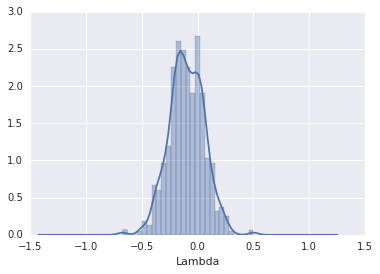

In [134]:
sns.distplot(table.Lambda)

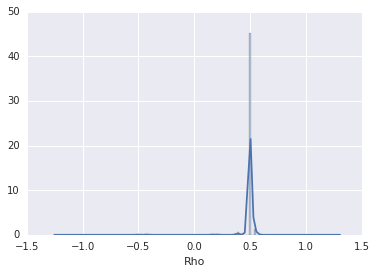

In [136]:
sns.distplot(table.Rho)

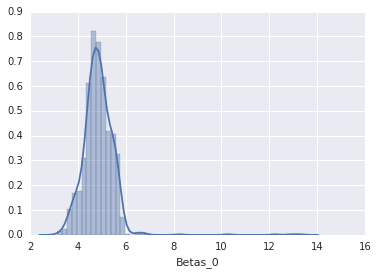

In [139]:
sns.distplot(table.Betas_0)

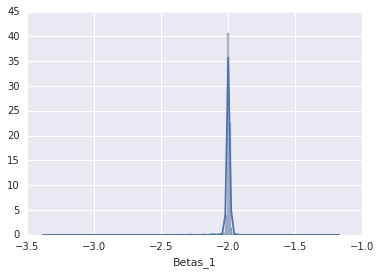

In [140]:
sns.distplot(table.Betas_1)

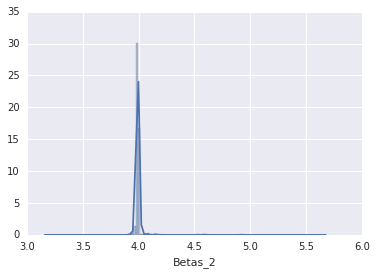

In [141]:
sns.distplot(table.Betas_2)

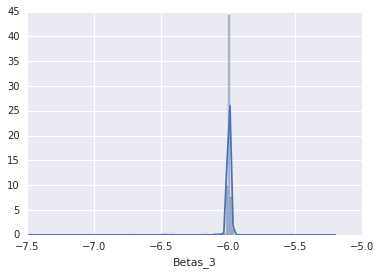

In [142]:
sns.distplot(table.Betas_3)

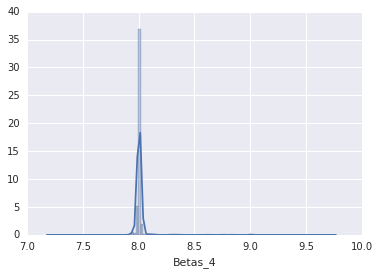

In [143]:
sns.distplot(table.Betas_4)

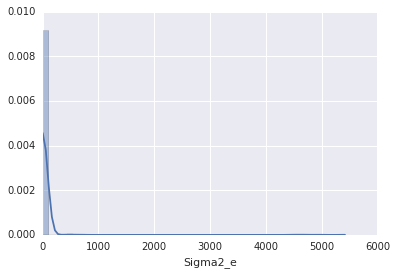

In [144]:
sns.distplot(table.Sigma2_e)

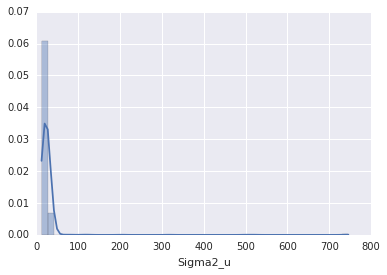

In [145]:
sns.distplot(table.Sigma2_u)